<a href="https://colab.research.google.com/github/stevengregori92/Learn-XGBoost/blob/main/Medical_Insurance.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install luwiji

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.3/40.3 MB 24.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 79.1 MB/s eta 0:00:00
  Created wheel for luwiji: filename=luwiji-1.2.1-py2.py3-none-any.whl size=40366830 sha256=e1093b401a5af606510fb488c00203ae2e64ddfe862684c1f5d653b040695d88
  Stored in directory: /root/.cache/pip/wheels/ba/90/9e/943ac5067e9cdc185d8f029a1d13278acd52839118acc06c9a
  Created wheel for jcopml: filename=jcopml-1.2.2-py2.py3-none-any.whl size=32178 sha256=30fd487652049e5aec35a53f8547172fc8ede2135706ced4bdeddfe6c4bb85c2
  Stored in directory: /root/.cache/pip/wheels/5e/06/58/749e5f1baf2932285758798a92793d4347888826160b025808
Successfully built luwiji jcopml


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease

#Import Dataset

In [2]:
!gdown https://drive.google.com/uc?id=1neS49pl7E-tXNOfCMIF65d8BPrzkKQlW

Downloading...
From: https://drive.google.com/uc?id=1neS49pl7E-tXNOfCMIF65d8BPrzkKQlW
To: /content/medic.zip
100% 32.4k/32.4k [00:00<00:00, 51.9MB/s]


In [4]:
!unzip /content/medic.zip

Archive:  /content/medic.zip
  inflating: Medical_insurance.csv   


In [31]:
df = pd.read_csv('Medical_insurance.csv')
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
2767,47,female,45.320,1,no,southeast,8569.86180
2768,21,female,34.600,0,no,southwest,2020.17700
2769,19,male,26.030,1,yes,northwest,16450.89470
2770,23,male,18.715,0,no,northwest,21595.38229


In [32]:
df.region.value_counts()

southeast    766
southwest    684
northwest    664
northeast    658
Name: region, dtype: int64

#Cleaning Dataset

,missing_value,%
age,0,0.0
sex,0,0.0
bmi,0,0.0
children,0,0.0
smoker,0,0.0
region,0,0.0
charges,0,0.0


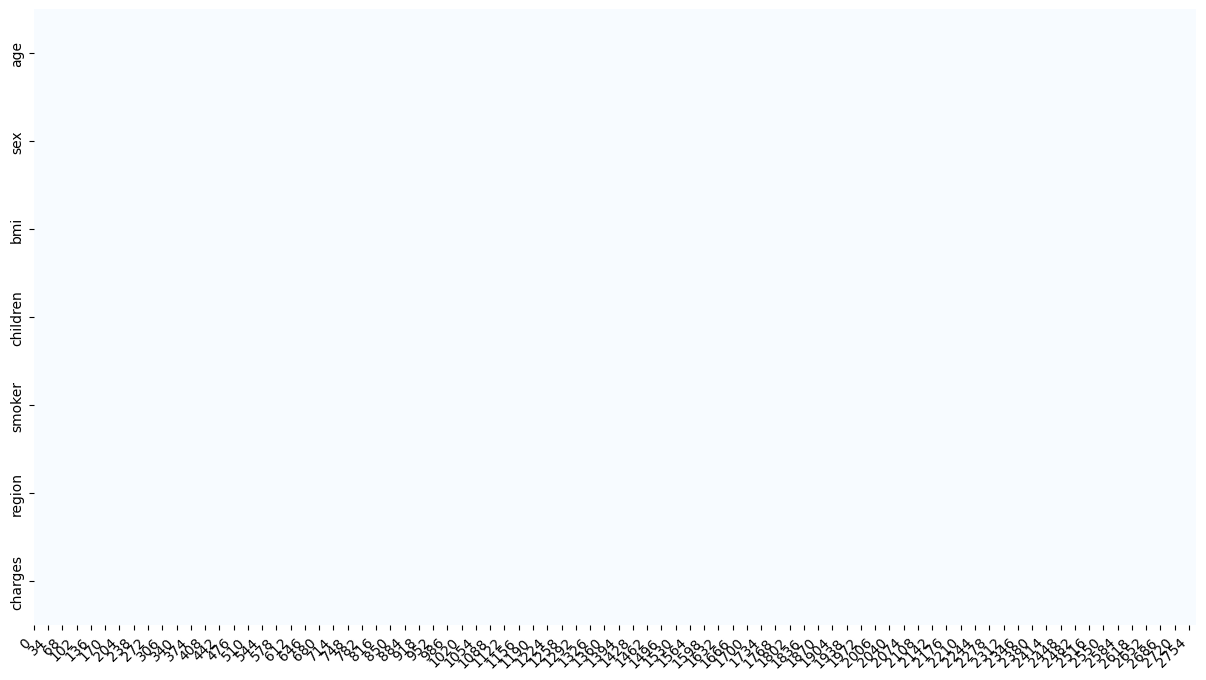

In [33]:
plot_missing_value(df, return_df=True)

#Dataset Splitting

In [34]:
X = df.drop(columns=['charges'])
y = df.charges

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2217, 6), (555, 6), (2217,), (555,))

#Training

In [35]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import random_search_params as rsp

In [36]:
X_train.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region'], dtype='object')

In [37]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(scaling='robust'), ['age', 'bmi', 'children']),
    ('categoric', cat_pipe(encoder='onehot'), ['sex', 'smoker', 'region'])
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', XGBRegressor(n_jobs=-1, random_state=42))
])

model = RandomizedSearchCV(pipeline, rsp.xgb_params, cv=3, n_iter = 50, n_jobs=-1, verbose=1, random_state = 42)
model.fit(X_train, y_train)

print(model.best_params_)
print(model.score(X_train, y_train), model.best_score_, model.score(X_test, y_test))

Fitting 3 folds for each of 50 candidates, totalling 150 fits
{'algo__colsample_bytree': 0.7545447962707789, 'algo__gamma': 8, 'algo__learning_rate': 0.13832094546570484, 'algo__max_depth': 9, 'algo__n_estimators': 161, 'algo__reg_alpha': 0.02001342062287998, 'algo__reg_lambda': 0.035868164986275514, 'algo__subsample': 0.43567451588694794}
0.9994732627658283 0.9141490920275217 0.9564278867458703


#Predict

In [38]:
df.iloc[0:2]

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.90,0,yes,southwest,16884.9240
1,18,male,33.77,1,no,southeast,1725.5523


In [39]:
data = [
    [19, 'female', 27.90, 0, 'yes', 'southwest'],
    [20, 'female', 29, 1, 'yes', 'southwest']
]

X_pred = pd.DataFrame(data, index=[1, 2], columns = X.columns)
X_pred

,age,sex,bmi,children,smoker,region
1,19,female,27.9,0,yes,southwest
2,20,female,29.0,1,yes,southwest


In [41]:
X_pred['charges'] = model.predict(X_pred)
X_pred

,age,sex,bmi,children,smoker,region,charges
1,19,female,27.9,0,yes,southwest,16885.529297
2,20,female,29.0,1,yes,southwest,17615.158203
